Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Schedule Azure Machine Learning Pipelines

This notebook supports the document [Tutorial: Schedule machine learning pipelines with Azure Machine Learning SDK for Python](https://docs.microsoft.com/azure/machine-learning/service/tutorial-pipeline-schedule). Please refer to that document for a detailed explanation.

The purpose is to programmatically schedule a pipeline to run on Azure. The sample is a data manipulation task that simulates preprocessing and runs every few minutes. Of course, a real data preprocessing step would presumably take much longer to run and would only be run once or perhaps twice a day as new data accumulated.

## Domain

The fake domain of this tutorial relates to colors. We are pretending that our input data consists of a set of "votes" for a color that we need to preprocess for our downstream ML system. The following cells write a domain file **color.py** file, then runs it, and show its basic (silly) functionality:

In [1]:
%%writefile color.py
from enum import Enum, unique
import numpy as np

@unique
class Color(Enum) : 
    Red = 0 
    Orange = 1 
    Yellow = 2
    Green = 3
    Blue = 4
    Indigo = 5
    Violet = 6

    @classmethod
    def randn_color(cls) : 
        v = np.random.randn()
        c = next((c for c in Color if v < (0.65 * (float(c.value) - 2.5))), Color.Violet)
        return c

Writing color.py


Run the file we just wrote in order to validate it:

In [2]:
%run color.py

Verify that our method `randn_color()` produces a normally-distributed shape:

In [3]:
cs = list(Color.randn_color().value for _ in range(1000))

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([ 51., 115., 198., 239., 211., 118.,  68.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

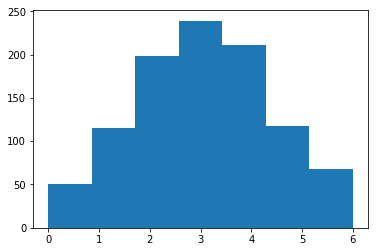

In [5]:
plt.hist(cs,len(Color))

## Generating and preprocessing data

This section writes our **preprocessing.py** file. 

To simulate some out-of-process data collection, the file **preprocessing.py** generates fake data and writes it to a file **unprocessed_data.csv**. 

Then, **preprocessing.py** reads that file, and "prepares the data for ML." In this case, it does some data transformation and normalizes the results. It writes the results to **processed_data.csv**. 

One scenario might be retraining or inferencing periodically. Another scenario, if data preparation was a very expensive step, would be to run a preprocessing pipeline on one schedule and retraining on another, slower, schedule. Azure ML Pipelines give you the flexibility to tackle either of those scenarios.


In [6]:
%%writefile preprocessing.py

from enum import Enum
from datetime import datetime,timedelta
from dateutil import parser
import os
import csv
import numpy as np
from sklearn.preprocessing import normalize

# Domain Data (for our example)
from color import Color

# Fake data section
def fake_data(storage_dir) : 

    def generate_fake_data(minutes, mu, sigma) :
        end_time = datetime.now()
        start_time = end_time - timedelta(minutes=minutes)
        # Generate a random amount of data
        amount_of_fake_data = minutes * int(mu + sigma * np.random.randn())
        # Generate at least 1 element
        amount_of_fake_data = 1 if amount_of_fake_data < 1 else amount_of_fake_data
        arrival_times = np.arange(start_time, end_time, timedelta(minutes = minutes / amount_of_fake_data)).astype(datetime)
        color_votes = list(Color.randn_color().name for _ in range(amount_of_fake_data))
        time_and_vote = zip(arrival_times, color_votes)
        return time_and_vote

    input_data_file = 'unprocessed_data.csv'
    input_path = os.path.join(storage_dir, input_data_file)
    # If first time, generate a bit more data 
    minutes_back = 1 if os.path.exists(input_path) else 10 
    data = generate_fake_data(minutes_back, 100, 50)
    with open(input_path, mode='w+') as f : 
        writer = csv.writer(f)
        writer.writerows(data)

# Example of ML task code (data preprocessing)
def read_raw_data(storage_dir) : 
    input_data_file = 'unprocessed_data.csv'
    input_path = os.path.join(storage_dir, input_data_file)
    if os.path.exists(input_path) : 
        with open(input_path, mode='r') as f : 
            reader = csv.reader(f)
            return list(reader)
    else :
        # If file doesn't exist, return empty list 
        return []

# Please note: this is just a silly example of converting and normalizing, e.g., "preprocessing stuff"     
def process_raw_data(raw_data) : 
    def convert(d) :
        for datum in d : 
            dt = parser.parse(datum[0])
            ts = int(dt.timestamp())
            c = Color[datum[1]].value
            yield (ts, c)
    processed_data = list(convert(raw_data))
    normalized_data = normalize(processed_data, axis = 0)
    return normalized_data

def write_processed_data(storage_dir, processed_data) : 
    output_data_file = 'processed_data.csv'
    output_path = os.path.join(storage_dir, output_data_file)

    # Note: Clobbers existing processed data -- fine in this example
    with open(output_path, mode='w') as f : 
        writer = csv.writer(f)
        writer.writerows(processed_data)

def main() : 
    storage_dir = '.'
    # Write some fake data to 'unprocessed_data.csv' -- normally data would be written via some external process
    fake_data(storage_dir)
    print("Beginning periodic data processing...")
    raw_data = read_raw_data(storage_dir)
    processed_data = process_raw_data(raw_data)
    write_processed_data(storage_dir, processed_data)
    print(f"Wrote {len(processed_data)} records")
    print("...Periodic data processing ended.")

if __name__== "__main__":
    main()

Writing preprocessing.py


Load the file we just wrote:


In [7]:
%run preprocessing.py


Beginning periodic data processing...
Wrote 31 records
...Periodic data processing ended.


<Figure size 432x288 with 0 Axes>

Create a source directory for our pipeline and move the script files to it:

In [8]:
import os
script_folder = os.path.join(os.getcwd(), "pipeline-scheduling-src")
os.makedirs(script_folder, exist_ok=True)

os.rename("color.py", f"{script_folder}/color.py")
os.rename("preprocessing.py", f"{script_folder}/preprocessing.py")

### Taking a look at the preprocessing

The **preprocessing.py** script reads unprocessed raw data and "prepares it" for ML. In this contrived situation, the steps are:

* Read the raw data
* Transform the human-readable record times into UNIX timestamp values 
* Transform the human-readable color "vote" into a numeric value
* Normalize both the timestamps and votes 
* Write the processed data 

In [9]:
raw_data = read_raw_data('.')[0:5]
raw_data

[['2019-10-09 12:01:54.359895', 'Indigo'],
 ['2019-10-09 12:01:56.295379', 'Indigo'],
 ['2019-10-09 12:01:58.230863', 'Orange'],
 ['2019-10-09 12:02:00.166347', 'Orange'],
 ['2019-10-09 12:02:02.101831', 'Violet']]

In [10]:
processed_data = process_raw_data(raw_data)
processed_data

array([[0.44721359, 0.53300179],
       [0.44721359, 0.53300179],
       [0.4472136 , 0.10660036],
       [0.4472136 , 0.10660036],
       [0.4472136 , 0.63960215]])

In [11]:
write_processed_data('.', processed_data)

## Creating and scheduling a pipeline



In [12]:
import azureml.core
azureml.core.VERSION

'1.0.65'

### Authenticate

Go to your Machine Learning workspace and download **config.json** to the directory in which this notebook is executing:

![Location of config.json file in Workspace](imgs/schedule-pipelines-download-config.png)

In [14]:
from azureml.core import Workspace 
ws = Workspace.from_config()

### Importing modules

Classes _not_ explained in the accompanying article:

In [15]:
from azureml.core import Datastore, Experiment
from azureml.core.runconfig import RunConfiguration
from azureml.data.data_reference import DataReference
from azureml.core.conda_dependencies import CondaDependencies
from azureml.pipeline.steps import PythonScriptStep
from azureml.pipeline.core import Pipeline

Classes explained in the accompanying article:

In [16]:
from azureml.pipeline.core import Schedule, ScheduleRecurrence
from azureml.pipeline.core import PublishedPipeline

### Create a pipeline

In [17]:
def config_compute() :
    compute_target = ws.compute_targets["cpu-compute"]

    compute_config = RunConfiguration()
    compute_config.target = "amlcompute"
    compute_config.amlcompute.vm_size = "STANDARD_D1_V2"
    dependencies = CondaDependencies()
    dependencies.add_pip_package("scikit-learn")
    compute_config.environment.python.conda_dependencies = dependencies
    return (compute_target, compute_config)

(compute_target, compute_config) = config_compute()

In [18]:
preprocessing_step = PythonScriptStep(
    script_name="preprocessing.py",
    arguments=[],
    inputs=[],
    outputs=[],
    compute_target=compute_target,
    runconfig = compute_config,
    source_directory="./pipeline-scheduling-src/"
)

In [19]:
steps = [ preprocessing_step ]

pipeline = Pipeline(workspace=ws, steps=steps)


WARNING - 'gpu_support' is no longer necessary; AzureML now automatically detects and uses nvidia docker extension when it is available. It will be removed in a future release.


In [20]:
experiment_name = "PipelineScheduling"
experiment = Experiment(ws, experiment_name) 

In [ ]:
pipeline_run = experiment.submit(pipeline)
pipeline_run.wait_for_completion()

Created step preprocessing.py [b4b904d9][6258a008-b9bc-4c9f-879c-bb878e1b1c6e], (This step will run and generate new outputs)
Submitted PipelineRun b4a4d30a-ac8e-4de6-871e-f59dfa057b73
Link to Azure Portal: https://mlworkspace.azure.ai/portal/subscriptions/65a1016d-0f67-45d2-b838-b8f373d6d52e/resourceGroups/laobri_0925_ml/providers/Microsoft.MachineLearningServices/workspaces/laobri_schedule_pipelines/experiments/PipelineScheduling/runs/b4a4d30a-ac8e-4de6-871e-f59dfa057b73
PipelineRunId: b4a4d30a-ac8e-4de6-871e-f59dfa057b73
Link to Portal: https://mlworkspace.azure.ai/portal/subscriptions/65a1016d-0f67-45d2-b838-b8f373d6d52e/resourceGroups/laobri_0925_ml/providers/Microsoft.MachineLearningServices/workspaces/laobri_schedule_pipelines/experiments/PipelineScheduling/runs/b4a4d30a-ac8e-4de6-871e-f59dfa057b73
PipelineRun Status: Running


StepRunId: a7390e37-de02-4aa7-afa1-a3e78222b7f9
Link to Portal: https://mlworkspace.azure.ai/portal/subscriptions/65a1016d-0f67-45d2-b838-b8f373d6d52e/re

## Publish and schedule a pipeline

In [ ]:
published_pipeline = pipeline_run.publish_pipeline("My published pipeline",f"Published on: {str(datetime.now())}", "0.0.5")

In [ ]:
published_pipeline

In [ ]:
published_pipeline.id

In [ ]:
# Note: Runs every few minutes, so you might want to slow that down for experimentation
recurrence = ScheduleRecurrence(frequency="Minute", interval=3)
schedule = Schedule.create(ws, name="MySchedule", pipeline_id=published_pipeline.id,
                          experiment_name=experiment_name, recurrence=recurrence)
schedule

## Cleaning up

In [ ]:
print(f"To retrieve the pipeline later, use it's `id`: {published_pipeline.id}")

Or, you can get the schedules running in your workspace:

In [ ]:
ss = Schedule.list(ws)

if len(ss) == 0 :
    print("There are currently no schedules in the workspace")

for s in ss : 
    print(s)


In [ ]:
# Doesn't work if pipeline is scheduled!
def disable_by_pipeline_id(ws, pipeline_id) : 
    p = PublishedPipeline.get(ws, id=pipeline_id)
    p.disable()
    return p
    
def disable_by_schedule_id(ws, schedule_id) : 
    s = next(s for s in Schedule.list(ws) if s.id == schedule_id)
    s.disable()
    return s


In [ ]:
schedule_id = ss[0].id
disable_by_schedule_id(ws,schedule_id)

In [ ]:
Schedule.list(ws)